### 2T - Logistic Regression

Dataset: https://www.kaggle.com/code/hunter0007/apple-m1-purchase-prediction-svm-model

Maestrante: Daniel Patricio Olivera Flores

In [1]:
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.gridspec import GridSpec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, auc, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate

In [2]:
def descomprimir_y_cargar_csv(archivo_zip, directorio_destino='.'):
    dataframes = {}

    with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
        zip_ref.extractall(directorio_destino)

        for nombre_archivo in zip_ref.namelist():
            if nombre_archivo.endswith('.csv'):
                nombre_variable = os.path.splitext(os.path.basename(nombre_archivo))[0]
                ruta_archivo = os.path.join(directorio_destino, nombre_archivo)
                dataframes[nombre_variable] = pd.read_csv(ruta_archivo)
    
    return dataframes

In [3]:
archivo_zip = 'M1_data.zip'
dataframes = descomprimir_y_cargar_csv(archivo_zip)
print(dataframes.keys())

dict_keys(['M1_data'])


In [4]:
df_train= dataframes['M1_data']
print("El dataset M1_data tiene: {} filas y {} columnas".format(df_train.shape[0], df_train.shape[1]))
df_head_train = df_train.head()
df_describe_train = df_train.describe()
print(df_head_train, "\n")
print(df_describe_train)

El dataset M1_data tiene: 133 filas y 22 columnas
  trust_apple  interest_computers  age_computer user_pcmac  \
0          No                   4             8         PC   
1         Yes                   2             4         PC   
2         Yes                   5             6         PC   
3         Yes                   2             6      Apple   
4         Yes                   4             4      Apple   

   appleproducts_count familiarity_m1  f_batterylife  f_price  f_size  \
0                    0             No              5        4       3   
1                    1             No              5        5       5   
2                    0             No              3        4       2   
3                    4             No              4        3       3   
4                    7            Yes              5        3       3   

   f_multitasking  ...  f_neural  f_synergy  f_performanceloss  \
0               4  ...         2          1                  1   
1     

In [5]:
print(df_train.dtypes,'\n')
valores_nulos_train = df_train.isnull().sum()
print("Cantidad de valores nulos por columna:")
print(valores_nulos_train)
total_valores_nulos_train = valores_nulos_train.sum()
if total_valores_nulos_train > 0:
    print(f"Total de valores nulos en el DataFrame: {total_valores_nulos_train}")
else:
    print("No existen valores nulos en el DataFrame.")
    

trust_apple            object
interest_computers      int64
age_computer            int64
user_pcmac             object
appleproducts_count     int64
familiarity_m1         object
f_batterylife           int64
f_price                 int64
f_size                  int64
f_multitasking          int64
f_noise                 int64
f_performance           int64
f_neural                int64
f_synergy               int64
f_performanceloss       int64
m1_consideration        int64
m1_purchase            object
gender                 object
age_group               int64
income_group            int64
status                 object
domain                 object
dtype: object 

Cantidad de valores nulos por columna:
trust_apple            0
interest_computers     0
age_computer           0
user_pcmac             0
appleproducts_count    0
familiarity_m1         0
f_batterylife          0
f_price                0
f_size                 0
f_multitasking         0
f_noise                0
f_performa

In [6]:
def select_object_features(df):

    df_objects = df.select_dtypes(include=['object'])

    return df_objects

df_objects = select_object_features(df_train)
df_objects.head(5)


,trust_apple,user_pcmac,familiarity_m1,m1_purchase,gender,status,domain
0,No,PC,No,Yes,Male,Student,Science
1,Yes,PC,No,No,Male,Employed,Finance
2,Yes,PC,No,Yes,Male,Student,IT & Technology
3,Yes,Apple,No,No,Female,Student,Arts & Culture
4,Yes,Apple,Yes,Yes,Male,Employed,Hospitality


In [7]:
def print_unique_values(df):
    for col in df.columns:
        print(f"Valores únicos en '{col}':", df[col].unique())

print_unique_values(df_objects)

Valores únicos en 'trust_apple': ['No' 'Yes']
Valores únicos en 'user_pcmac': ['PC' 'Apple' 'Hp' 'Other']
Valores únicos en 'familiarity_m1': ['No' 'Yes']
Valores únicos en 'm1_purchase': ['Yes' 'No']
Valores únicos en 'gender': ['Male' 'Female']
Valores únicos en 'status': ['Student' 'Employed' 'Retired' 'Student ant employed' 'Unemployed'
 'Self-Employed']
Valores únicos en 'domain': ['Science' 'Finance' 'IT & Technology' 'Arts & Culture' 'Hospitality'
 'Politics' 'Social Sciences' 'Administration & Public Services'
 'Education' 'Engineering' 'Marketing' 'Healthcare' 'Business' 'Retired'
 'Economics' 'Law' 'Agriculture' 'Communication ' 'Realestate' 'Logistics'
 'Consulting ' 'Retail']


In [8]:
from sklearn.preprocessing import LabelEncoder

def label_encode_df(df):
    df_encoded = df.copy()

    for col in df.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col])

    return df_encoded

df_encoded = label_encode_df(df_objects)
df_encoded.head(5)


,trust_apple,user_pcmac,familiarity_m1,m1_purchase,gender,status,domain
0,0,3,0,1,1,3,20
1,1,3,0,0,1,0,9
2,1,3,0,1,1,3,12
3,1,0,0,0,0,3,2
4,1,0,1,1,1,0,11


In [9]:
def merge_encoded_df(df, encoded_df):
    df_m1 = df.copy()
    df_m1.update(encoded_df)
    return df_m1

def convert_to_int(df):
    df_int = df.copy() 
    for col in df_int.columns:
        df_int[col] = df_int[col].astype('int64')
    return df_int

df_train = merge_encoded_df(df_train, df_encoded)
df_train = convert_to_int(df_train)

columna = df_train['m1_purchase']
df_train.drop(columns=['m1_purchase'], inplace=True)
df_train['m1_purchase'] = columna

print(df_train.dtypes,'\n')
df_train.head(5)

trust_apple            int64
interest_computers     int64
age_computer           int64
user_pcmac             int64
appleproducts_count    int64
familiarity_m1         int64
f_batterylife          int64
f_price                int64
f_size                 int64
f_multitasking         int64
f_noise                int64
f_performance          int64
f_neural               int64
f_synergy              int64
f_performanceloss      int64
m1_consideration       int64
gender                 int64
age_group              int64
income_group           int64
status                 int64
domain                 int64
m1_purchase            int64
dtype: object 



,trust_apple,interest_computers,age_computer,user_pcmac,appleproducts_count,familiarity_m1,f_batterylife,f_price,f_size,f_multitasking,...,f_neural,f_synergy,f_performanceloss,m1_consideration,gender,age_group,income_group,status,domain,m1_purchase
0,0,4,8,3,0,0,5,4,3,4,...,2,1,1,1,1,2,2,3,20,1
1,1,2,4,3,1,0,5,5,5,3,...,2,2,4,2,1,2,3,0,9,0
2,1,5,6,3,0,0,3,4,2,4,...,2,2,2,4,1,2,2,3,12,1
3,1,2,6,0,4,0,4,3,3,4,...,4,4,3,2,0,2,2,3,2,0
4,1,4,4,0,7,1,5,3,3,4,...,3,4,4,4,1,5,7,0,11,1


In [10]:
def scatter_plots_yield_vs_features(df, target_col):
    features = [col for col in df.columns if col != target_col]
    n_cols = 4
    n_rows = (len(features) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        sns.scatterplot(data=df, x=feature, y=target_col, hue=target_col, palette='YlOrRd', ax=ax)
        ax.grid(True)
        ax.set_title(f'{target_col} vs {feature}')

    plt.tight_layout()
    plt.show()

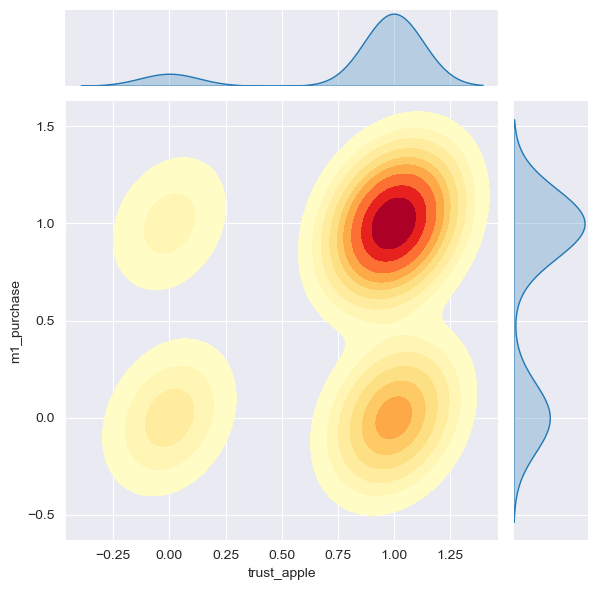

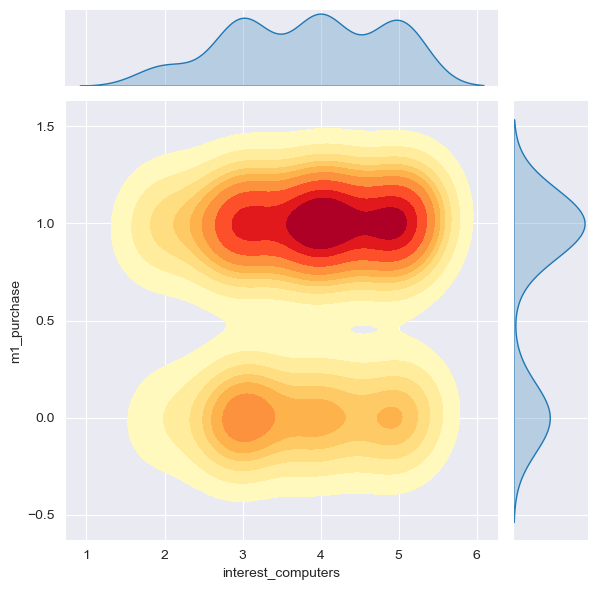

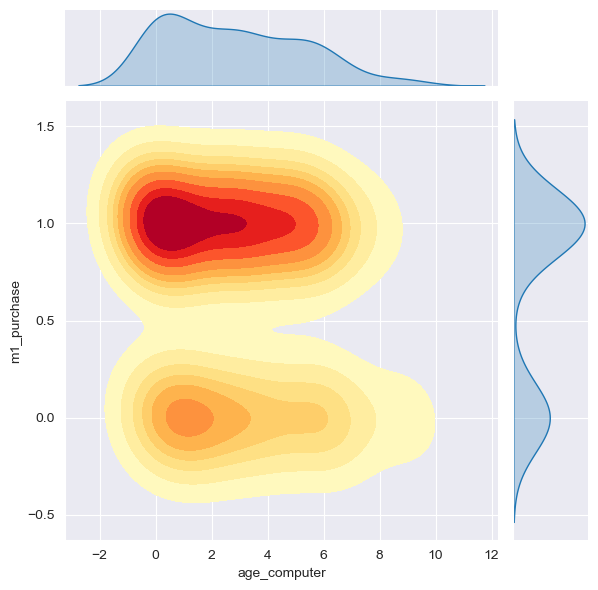

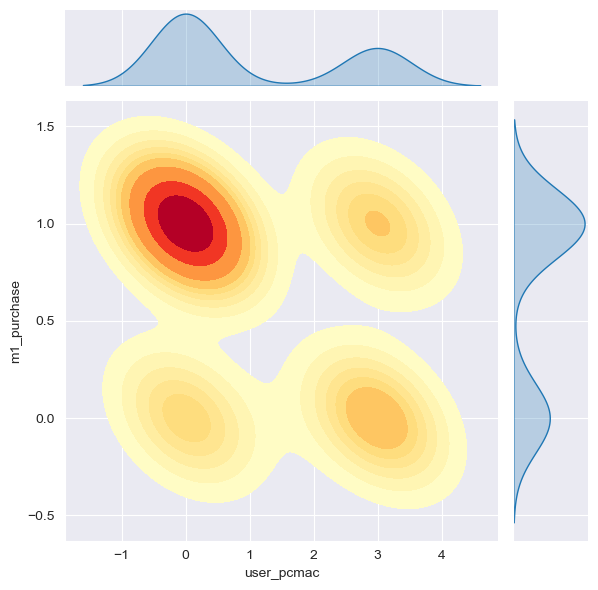

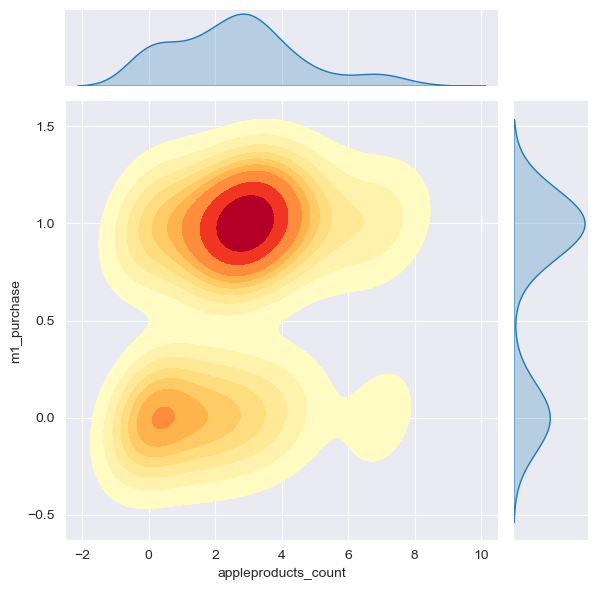

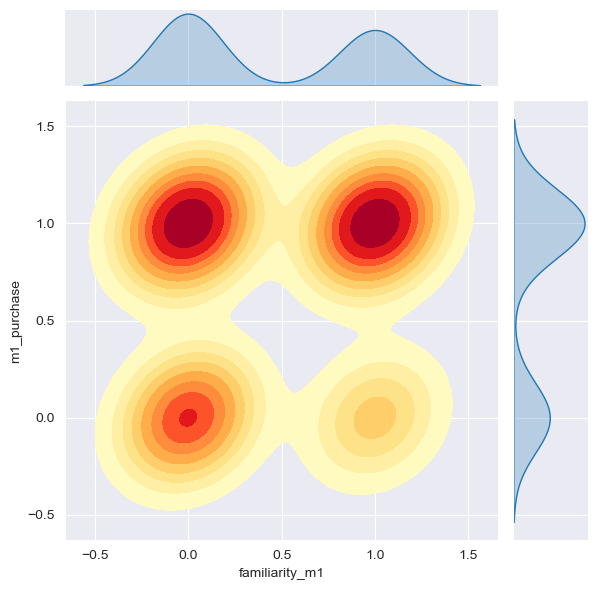

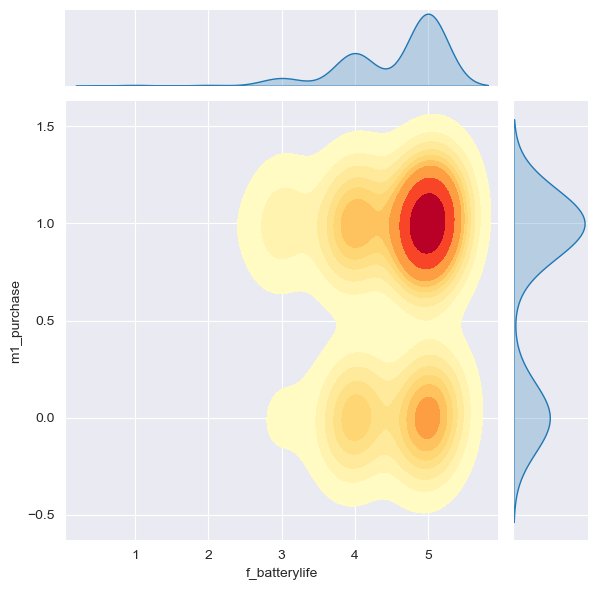

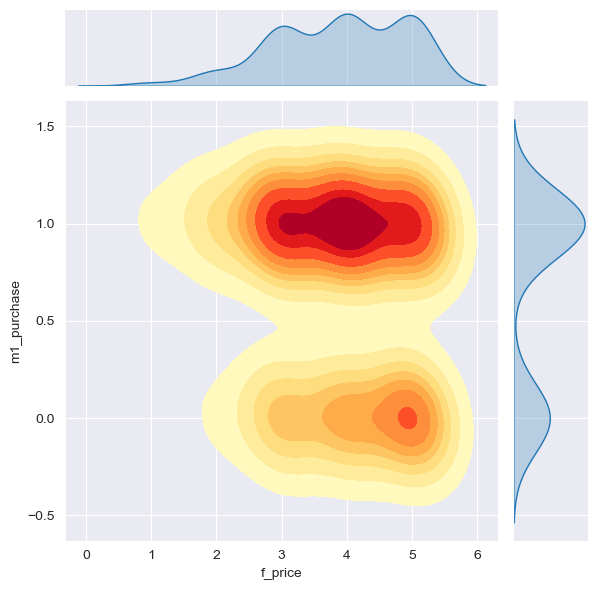

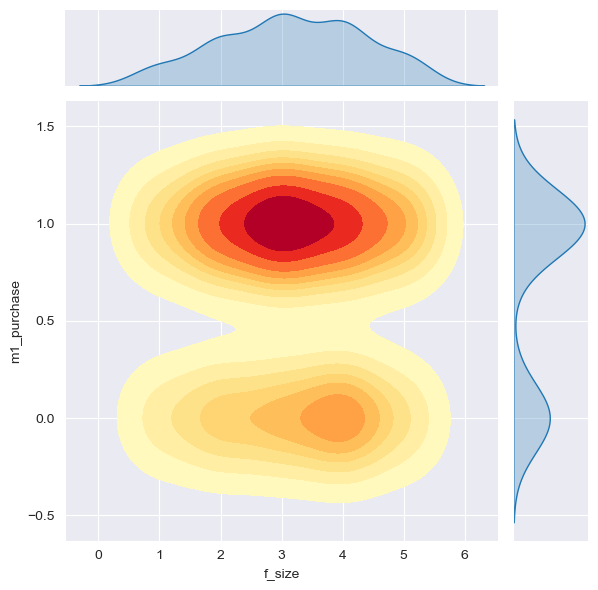

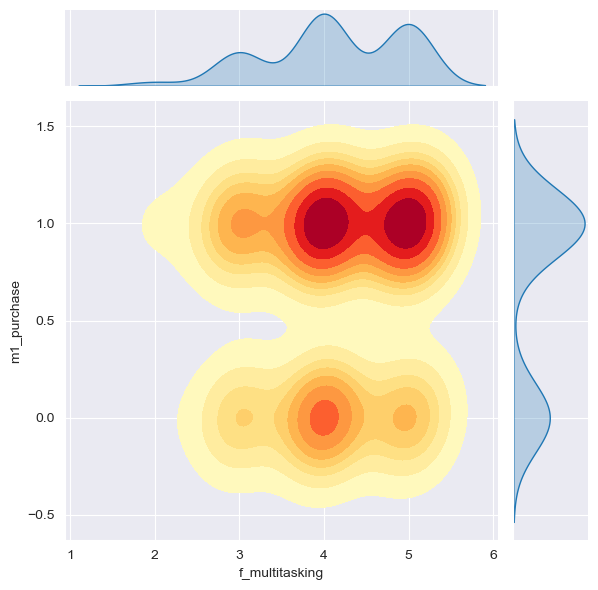

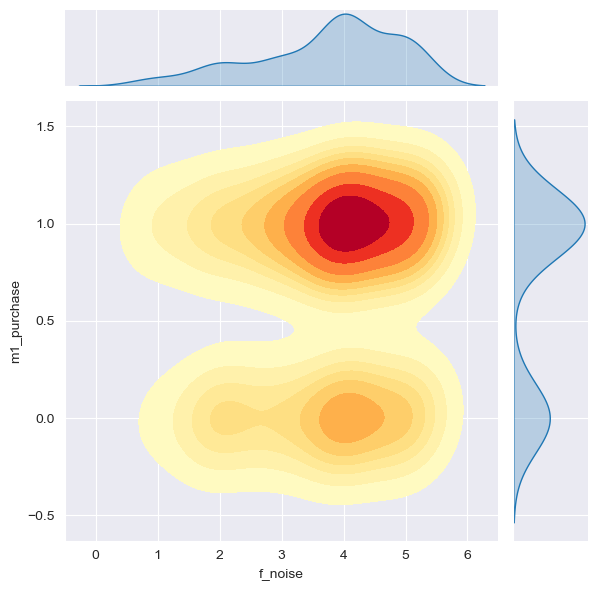

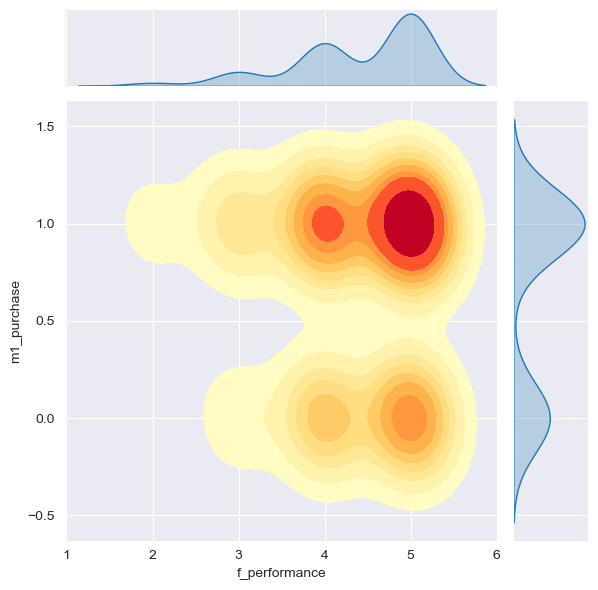

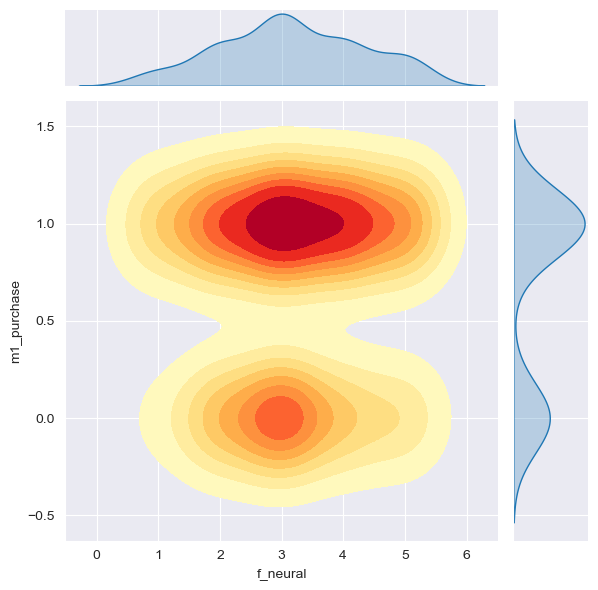

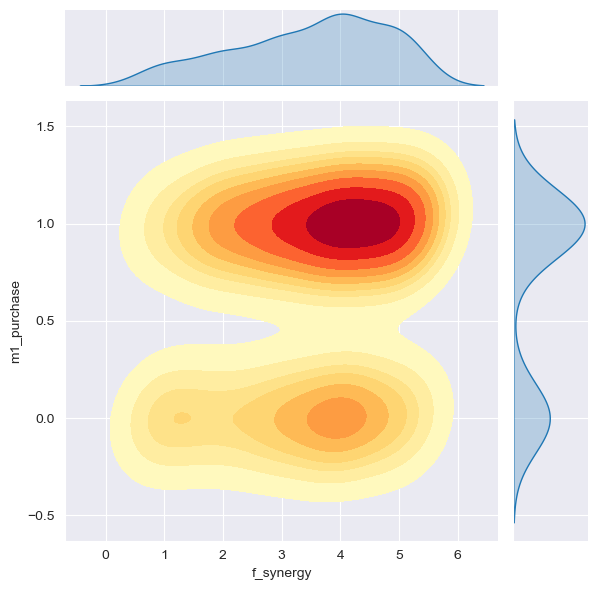

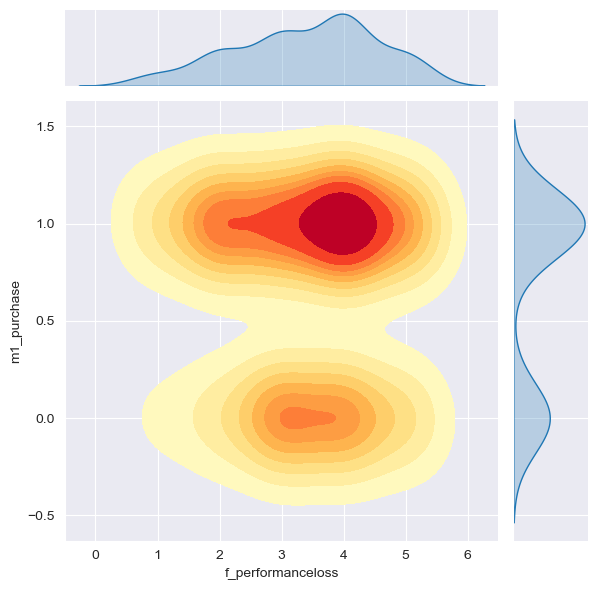

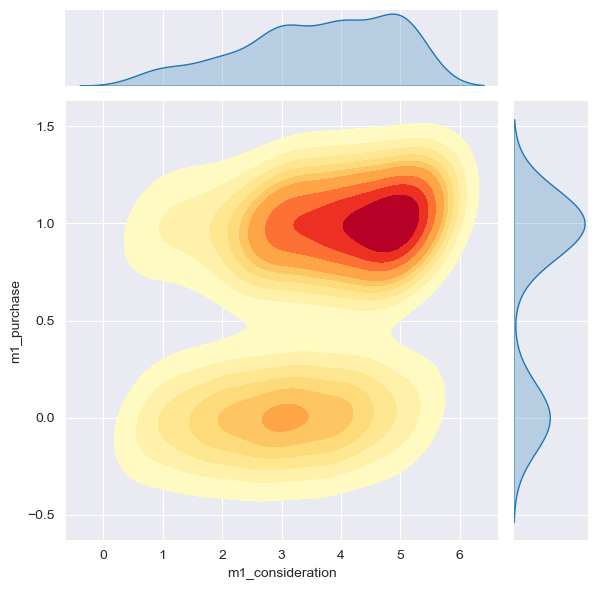

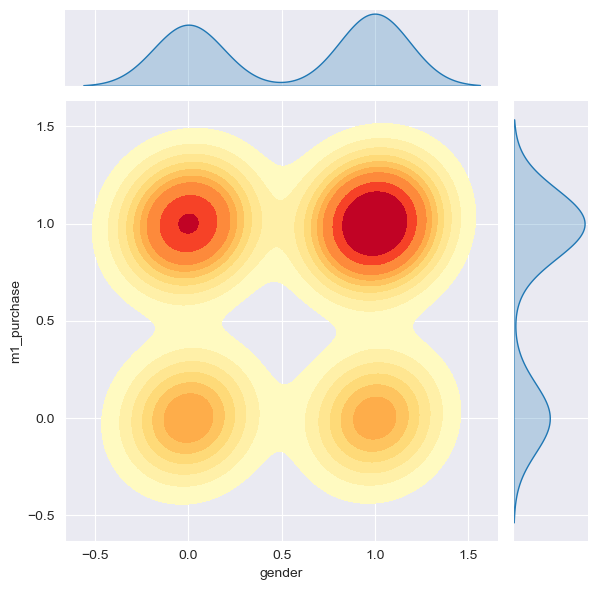

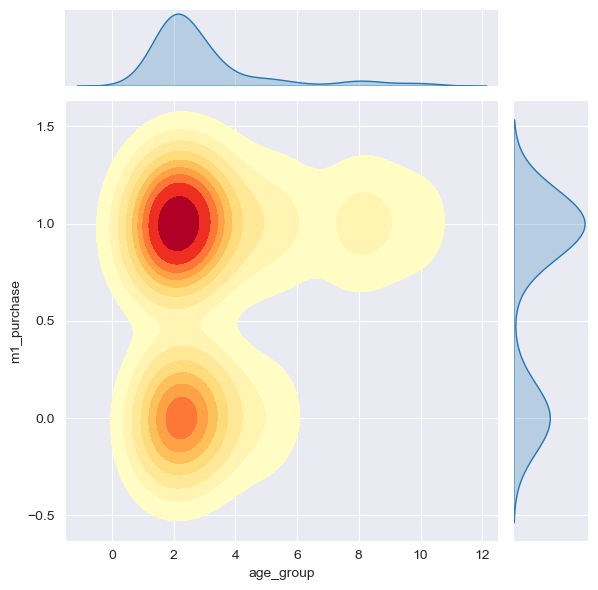

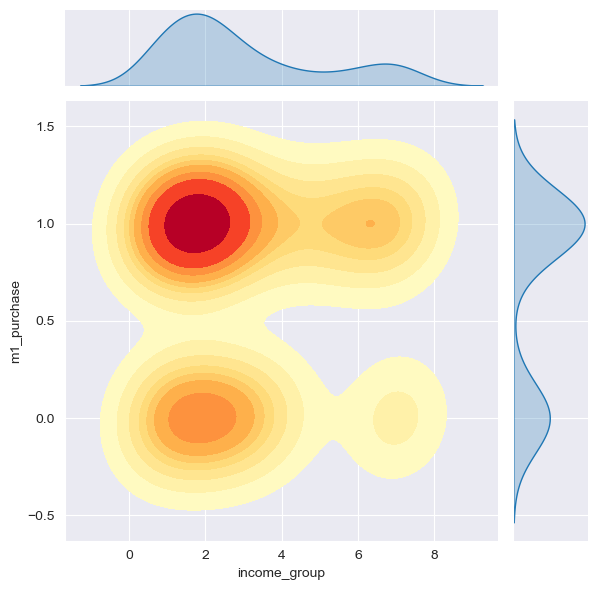

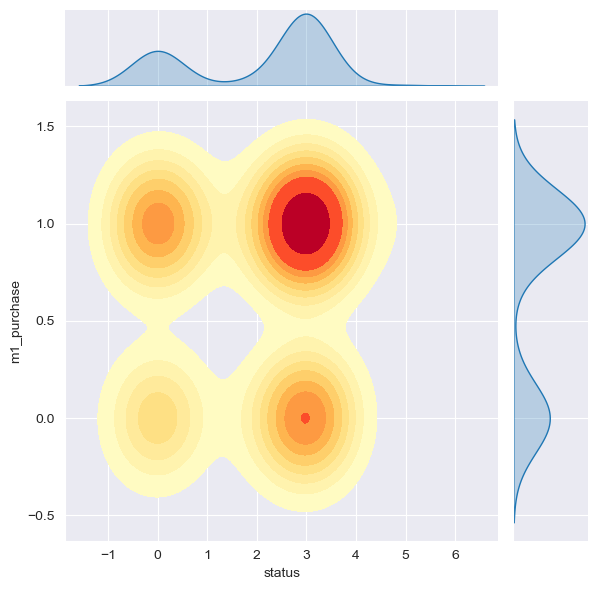

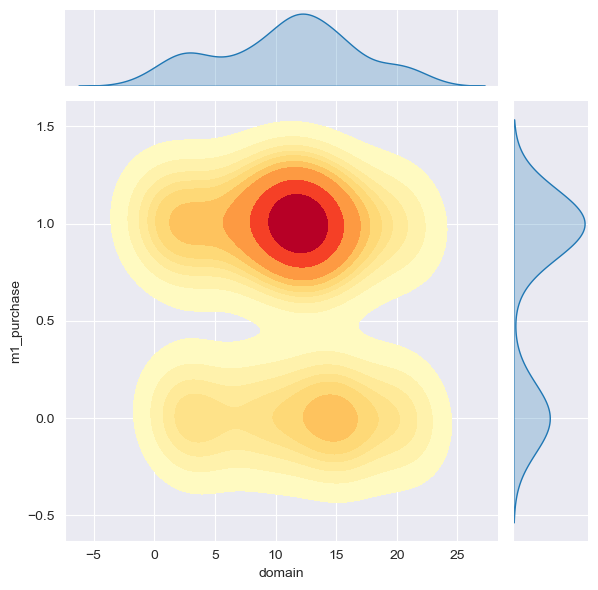

In [26]:
def plot_jointplot(df, y_col, columns, kinds):
    for column in columns:
        sns.jointplot(data=df, x=column, y=y_col, kind=kinds, cmap='YlOrRd', fill=True)
        plt.xlabel(column)
        plt.ylabel(y_col)
        plt.show()

columnas = df_train.iloc[:, :-1].columns
plot_jointplot(df_train, 'm1_purchase', columnas, 'kde')

In [12]:
def plot_jointplot(df, y_col, columns):
    n_columns = len(columns)
    fig = plt.figure(figsize=(6 * n_columns, 6))
    grid = GridSpec(1, n_columns, figure=fig)
    
    for i, column in enumerate(columns):
        ax_joint = fig.add_subplot(grid[0, i])
        ax_marg_x = fig.add_subplot(grid[0, i], sharex=ax_joint)
        ax_marg_y = fig.add_subplot(grid[0, i], sharey=ax_joint)
        sns.kdeplot(data=df, x=column, y=y_col, ax=ax_joint, cmap='YlOrRd', fill=True)
        ax_joint.set_title(f'Joint plot: {y_col} vs {column}')
        ax_marg_x.set_axis_off()
        ax_marg_y.set_axis_off()

    plt.tight_layout()
    plt.show()

In [13]:
def graficar_correlaciones_cat(df1):
    corr1 = df1.corr()
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8))
    sns.heatmap(corr1, annot=True, cmap='YlOrRd', vmin=-1, vmax=1, ax=ax1, fmt='.2f', linewidths=0.5, linecolor="black")
    plt.tight_layout()
    plt.show()

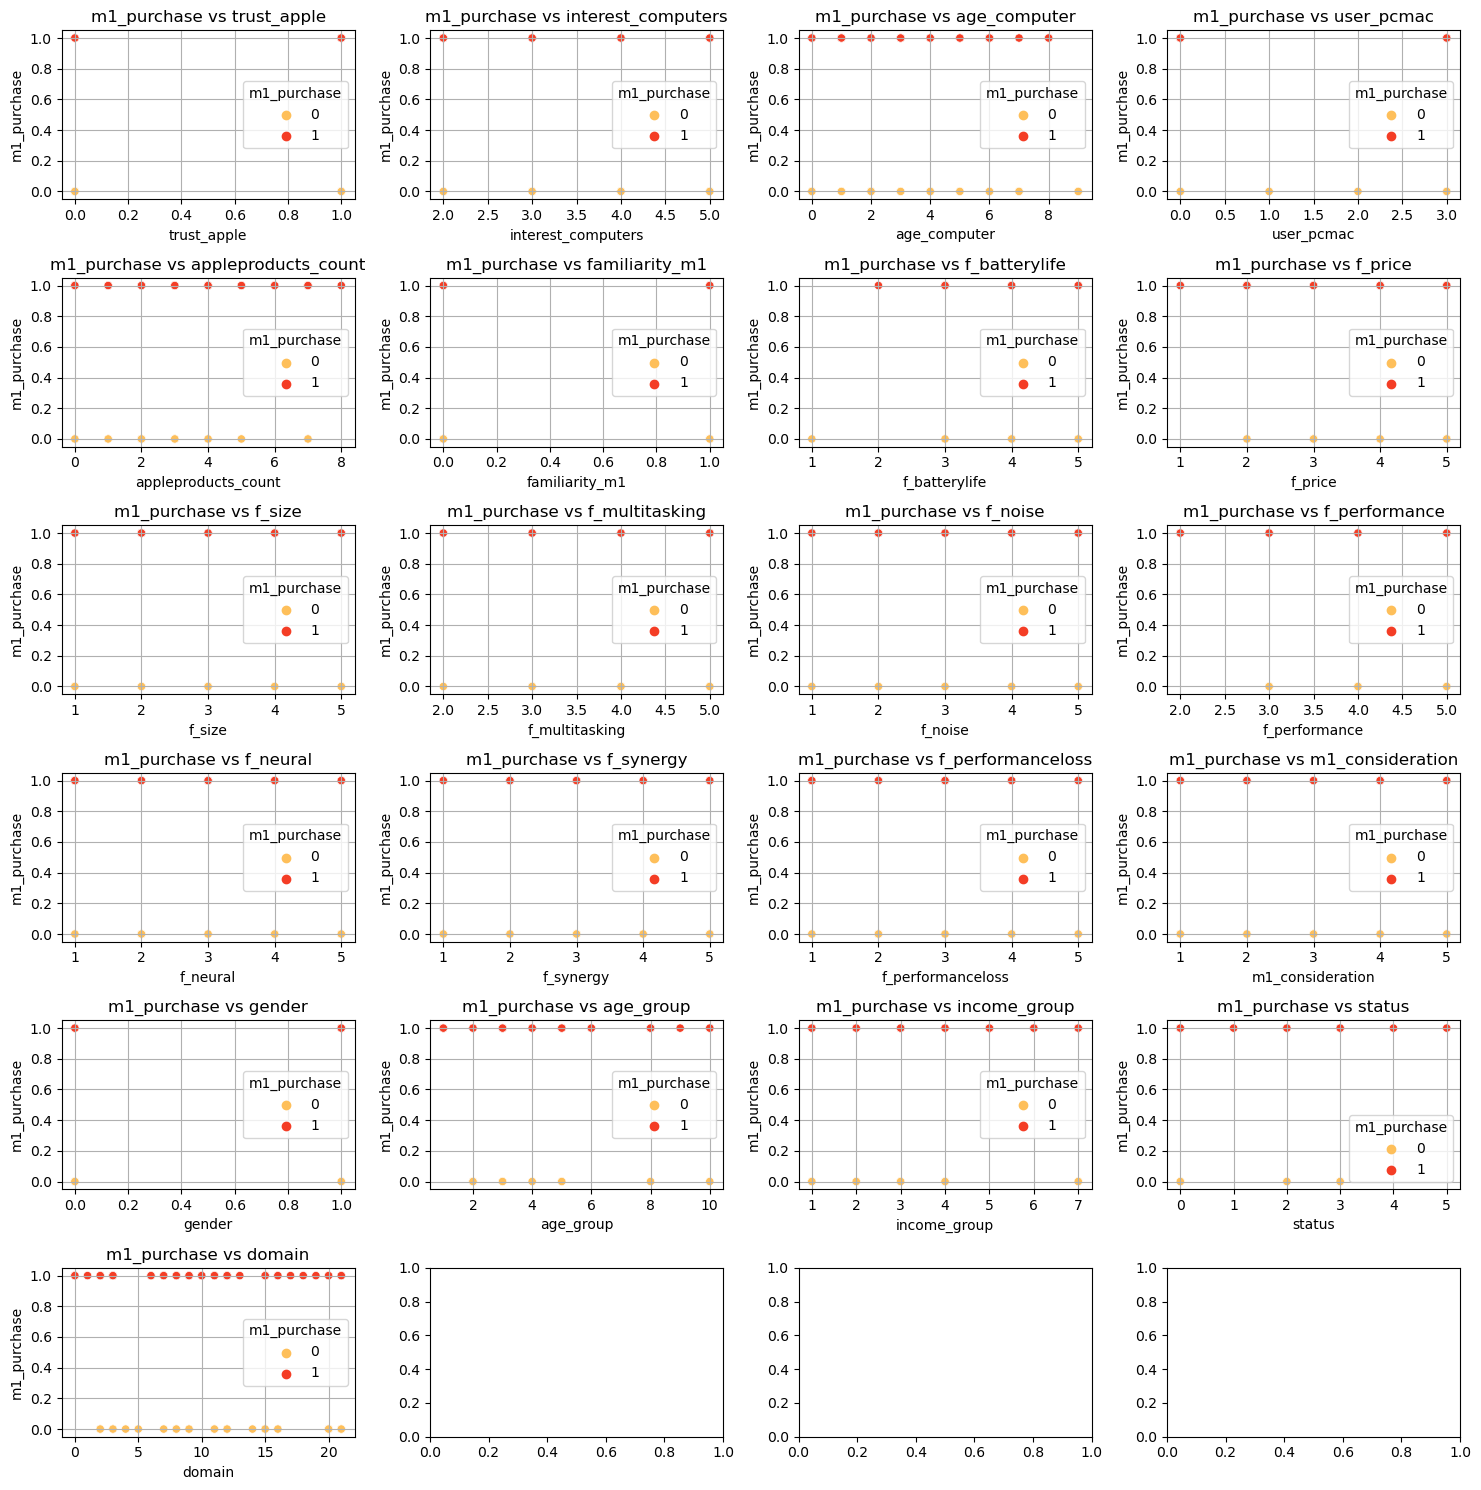

In [14]:
scatter_plots_yield_vs_features(df_train, target_col='m1_purchase')

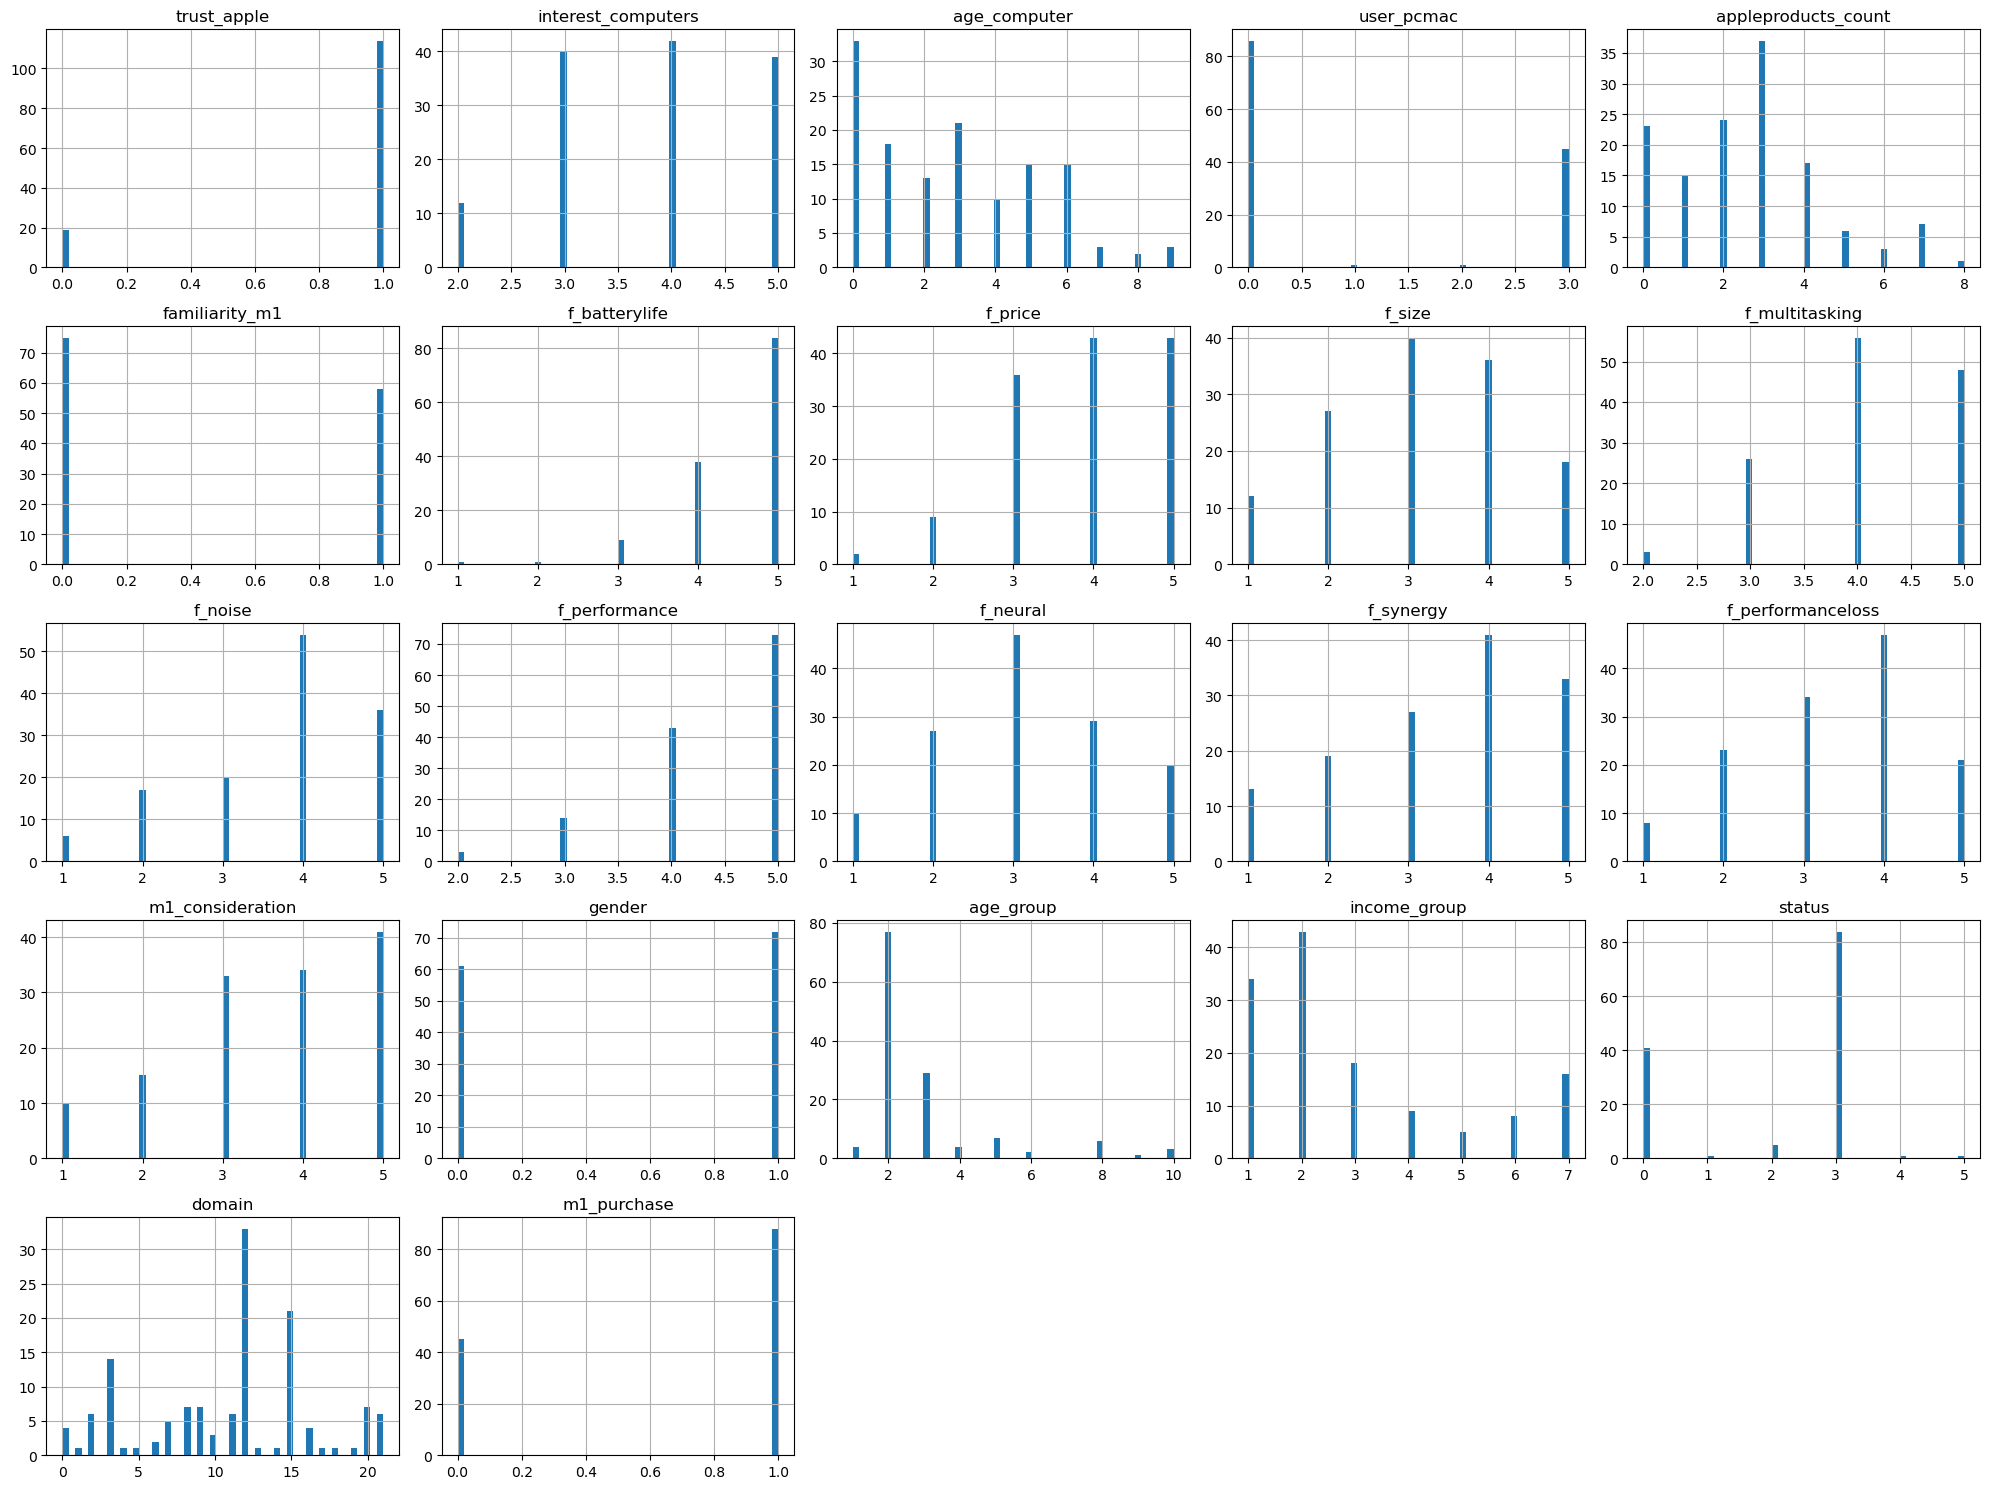

In [15]:
import matplotlib.pyplot as plt

df_train.hist(bins=50, figsize=(20,15))
plt.tight_layout()  # para evitar la superposición de los títulos de los subplots
plt.show()

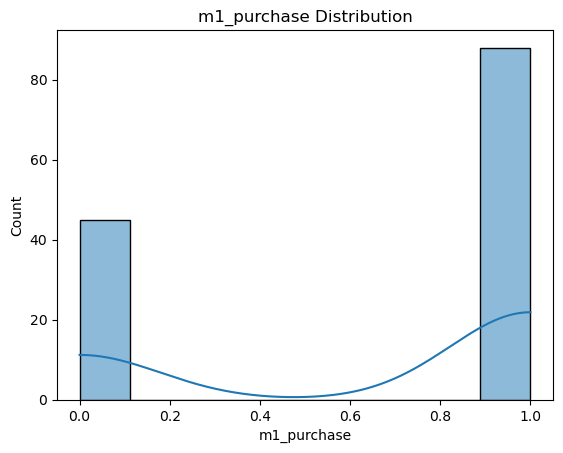

In [16]:
target_col_cat = 'm1_purchase'
sns.histplot(df_train[target_col_cat], kde=True)
plt.title(f'{target_col_cat} Distribution')
plt.show()

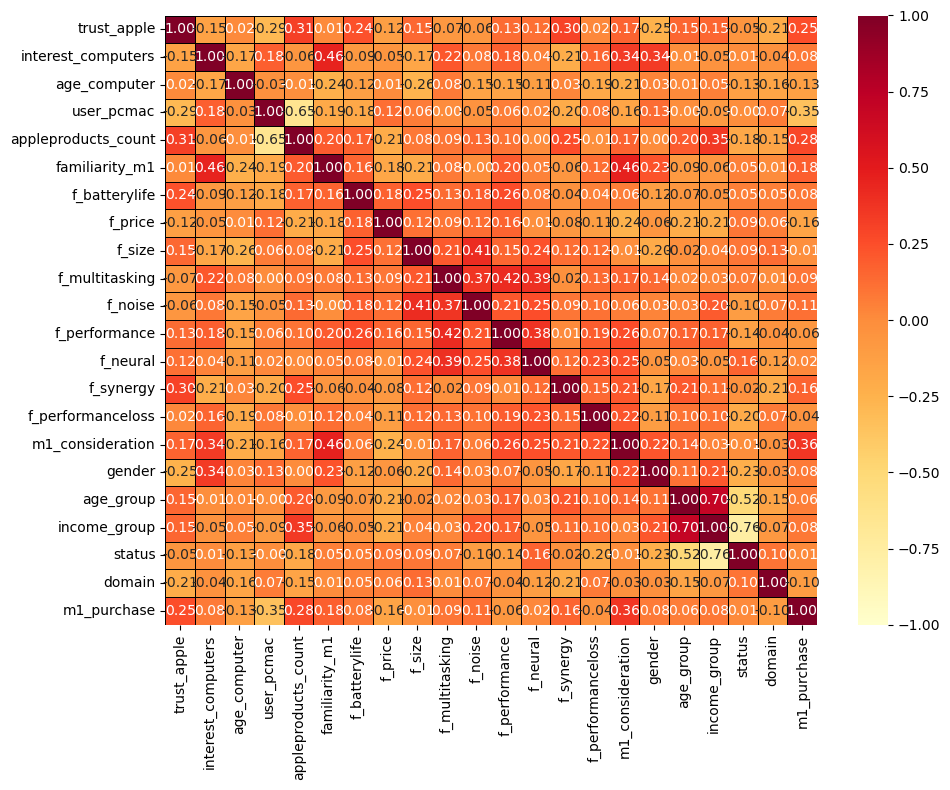

In [18]:
graficar_correlaciones_cat(df_train)

In [19]:
def standardize_and_normalize(df):
    scaler_std = StandardScaler()
    df_standardized = pd.DataFrame(scaler_std.fit_transform(df), columns=df.columns)

    scaler_norm = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler_norm.fit_transform(df), columns=df.columns)

    return df_standardized, df_normalized, scaler_std, scaler_norm

df_train_std, df_train_norm, scaler_std_train, scaler_norm_train = standardize_and_normalize(df_train)

In [20]:
df_train_std, df_train_norm, scaler_std_train, scaler_norm_train_cat = standardize_and_normalize(df_train)
df_train_std['m1_purchase'] = df_train_std['m1_purchase'] * scaler_std_train.scale_[-1] + scaler_std_train.mean_[-1]

X = df_train_std.drop('m1_purchase', axis=1)
y = df_train_std['m1_purchase']

print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=957)
print("Instancias X_train (category) dataset: ", X_train.shape)
print("Instancias y_train (category) dataset: ", y_train.shape)
print("Instancias X_test (category) dataset: ", X_test.shape)
print("Instancias y_test (category) dataset: ", y_test.shape)
print(y.value_counts())

Shape of X: (133, 21)
Shape of y: (133,)
Instancias X_train (category) dataset:  (106, 21)
Instancias y_train (category) dataset:  (106,)
Instancias X_test (category) dataset:  (27, 21)
Instancias y_test (category) dataset:  (27,)
1.0    88
0.0    45
Name: m1_purchase, dtype: int64


In [21]:
def logistic_regression(X_train, y_train, X_test, y_test):
    logistic_regression_1 = LogisticRegression(solver='liblinear', random_state=957)
    logistic_regression_1.fit(X_train, y_train)
    y_pred = logistic_regression_1.predict(X_test)

    print("Metricas de evaluacion en el conjunto de prueba:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1: {f1_score(y_test, y_pred):.2f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Precision:",accuracy_score(y_test, y_pred)*100,"%")
    
    return logistic_regression_1

logistic_regression_1 = logistic_regression(X_train, y_train, X_test, y_test)

Metricas de evaluacion en el conjunto de prueba:
Accuracy: 0.74
Precision: 0.82
Recall: 0.78
F1: 0.80
[[ 6  3]
 [ 4 14]]
              precision    recall  f1-score   support

         0.0       0.60      0.67      0.63         9
         1.0       0.82      0.78      0.80        18

    accuracy                           0.74        27
   macro avg       0.71      0.72      0.72        27
weighted avg       0.75      0.74      0.74        27

Precision: 74.07407407407408 %


In [29]:
def logistic_regression_kfold(X_train, y_train, X_test, y_test, n_splits=10):
    logistic_regression_2 = LogisticRegression(solver='liblinear', random_state=957)
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    cv_results_lr = cross_validate(logistic_regression_2, X_train, y_train, cv=n_splits, scoring=scoring)
    logistic_regression_2.fit(X_train, y_train)
    y_pred = logistic_regression_2.predict(X_test)

    print("Metricas de evaluacion en el conjunto de prueba:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1: {f1_score(y_test, y_pred):.2f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Precision:",accuracy_score(y_test, y_pred)*100,"%")

    print("\nMetricas promedio durante la validacion cruzada K-fold:")
    for metric in scoring:
        mean_score = cv_results_lr[f"test_{metric}"].mean()
        print(f"{metric.capitalize()}: {mean_score:.2f}")
        
    return logistic_regression_2

logistic_regression_2 = logistic_regression_kfold(X_train, y_train, X_test, y_test)

Metricas de evaluacion en el conjunto de prueba:
Accuracy: 0.74
Precision: 0.82
Recall: 0.78
F1: 0.80
[[ 6  3]
 [ 4 14]]
              precision    recall  f1-score   support

         0.0       0.60      0.67      0.63         9
         1.0       0.82      0.78      0.80        18

    accuracy                           0.74        27
   macro avg       0.71      0.72      0.72        27
weighted avg       0.75      0.74      0.74        27

Precision: 74.07407407407408 %

Metricas promedio durante la validacion cruzada K-fold:
Accuracy: 0.63
Precision: 0.74
Recall: 0.74
F1: 0.72


In [23]:
def plot_roc_auc(model, X_train, y_train, X_test, y_test):
    
    sns.set_style("darkgrid")
    tmp = model.fit(X_train, y_train.ravel())
    if hasattr(tmp, "decision_function"):
        y_pred_sample_score = tmp.decision_function(X_test)
    else:
        y_pred_sample_score = tmp.predict_proba(X_test)[:, 1]
    logit_roc_auc = roc_auc_score(y_test, y_pred_sample_score)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score)
    plt.figure()
    plt.plot(fpr, tpr, label='{name} Model (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

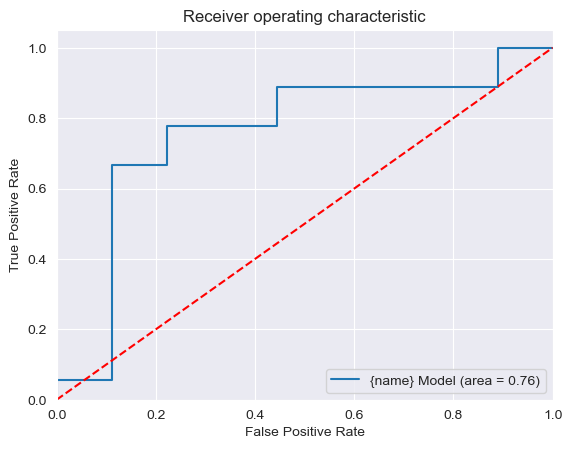

In [24]:
plot_roc_auc(logistic_regression_1, X_train, y_train, X_test, y_test)

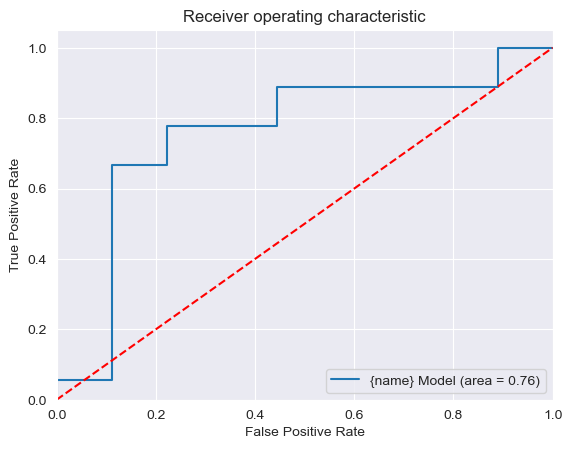

In [25]:
plot_roc_auc(logistic_regression_2, X_train, y_train, X_test, y_test)